<a href="https://www.kaggle.com/code/ramirazodi/ca-house-price-lr-pipe?scriptVersionId=157857811" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# This notebook trains a hybdird linear regression ensemble using advanced scikit-pipeline structures 

Rather than utilizing tree models, neural networks, support vector machines, or even k-nearest neighbors, this notebook aims to just focus on linear regression models and combine that with advanced scikit-learn pipeline and customization techniques to create a dynamic pipeline which is ultimately optimized through a detailed grid search. Every element of the pipeline from imputation, scaling, transformation, model weightings, and hybrid business guardrails are optimized and can be tweaked from the grid search parameters. The notebook serves as a framework and placeholder for developing advanced ML pipelines using scikit learn frameworks. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import platform
import psutil
import sys
import sklearn
import matplotlib
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures 
from sklearn.preprocessing import PowerTransformer, SplineTransformer, KBinsDiscretizer, FunctionTransformer, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, f_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import VotingRegressor
from IPython.display import display, HTML

In [2]:
# Display library versions and system info
def print_sys_info():
    print(f"Python Version: {sys.version}")
    print(f"Numpy version: {np.__version__}")
    print(f"Pandas version: {pd.__version__}")
    print(f"Scikit-Learn version: {sklearn.__version__}")
    print(f"Matplotlib version: {matplotlib.__version__}")
    print(f"Seaborn version: {sns.__version__}")
    print("\nSystem Information:")
    print(f"System: {platform.system()}")
    print(f"Machine: {platform.machine()}")
    print(f"Platform: {platform.platform()}")
    print(f"Processor: {platform.processor()}")
    print(f"CPU Count: {psutil.cpu_count(logical=True)}")
    print(f"Total Memory: {psutil.virtual_memory().total / (1024**3):.2f} GB")
    
    # RAM Details
    svmem = psutil.virtual_memory()
    print(f"Total RAM: {svmem.total / (1024.0 ** 3):.2f} GB")
    print(f"Available RAM: {svmem.available / (1024.0 ** 3):.2f} GB")
    print(f"Used RAM: {svmem.used / (1024.0 ** 3):.2f} GB")

print_sys_info()

Python Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
Numpy version: 1.24.3
Pandas version: 2.0.3
Scikit-Learn version: 1.2.2
Matplotlib version: 3.7.4
Seaborn version: 0.12.2

System Information:
System: Linux
Machine: x86_64
Platform: Linux-5.15.133+-x86_64-with-glibc2.31
Processor: x86_64
CPU Count: 4
Total Memory: 31.36 GB
Total RAM: 31.36 GB
Available RAM: 30.19 GB
Used RAM: 0.72 GB


In [3]:
# Quick exploration of data files in the kaggle inputs folder
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Read California Houst Prices dataset
df_raw = pd.read_csv('../input/house-price/1553768847-housing.csv')

/kaggle/input/mnist100/mnist_compressed.npz
/kaggle/input/house-price/1553768847-housing.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/world-energy-consumption/World Energy Consumption.csv


In [4]:
# Utilize set_ouput API of scikit to ensure all transformers output pandas dataframes instead of numpy arrays
set_config(transform_output='pandas')

In [5]:
display(df_raw.columns)
display(df_raw.shape)
display(df_raw)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

(20640, 10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


# EDA

In [6]:
df_eda = df_raw.copy()

In [7]:
print(f'Number of columns that include NaN values: {df_eda.isna().any().sum()}')
print(f'Total number of NaN values in the dataframe: {df_eda.isna().sum().sum()}')
print(f'Dataframe size: {df_eda.size}')
print(f'Dataframe NaN value counts % of dataframe size: {round(df_eda.isna().sum().sum()/df_eda.size*100, 2)}\n')
display(df_eda.info())

Number of columns that include NaN values: 1
Total number of NaN values in the dataframe: 207
Dataframe size: 206400
Dataframe NaN value counts % of dataframe size: 0.1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


None

In [8]:
display(df_eda.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
df_eda = (df_eda
          .assign(
              total_bedrooms=lambda df_: df_.total_bedrooms.fillna(df_.total_bedrooms.mean()),
              pop_per_house=lambda df_: df_.population.div(df_.households).round(1),
              rooms_per_house=lambda df_: df_.total_rooms.div(df_.households).round(1),
              beds_per_house=lambda df_: df_.total_bedrooms.div(df_.households).round(1),
              beds_to_room_ratio=lambda df_: df_.total_bedrooms.div(df_.total_rooms).fillna(0).round(1),
          )
         )

df_eda = pd.get_dummies(data=df_eda, dtype=int)

display(df_eda.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  int64  
 3   total_rooms                 20640 non-null  int64  
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  int64  
 6   households                  20640 non-null  int64  
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  int64  
 9   pop_per_house               20640 non-null  float64
 10  rooms_per_house             20640 non-null  float64
 11  beds_per_house              20640 non-null  float64
 12  beds_to_room_ratio          20640 non-null  float64
 13  ocean_proximity_<1H OCEAN   206

None

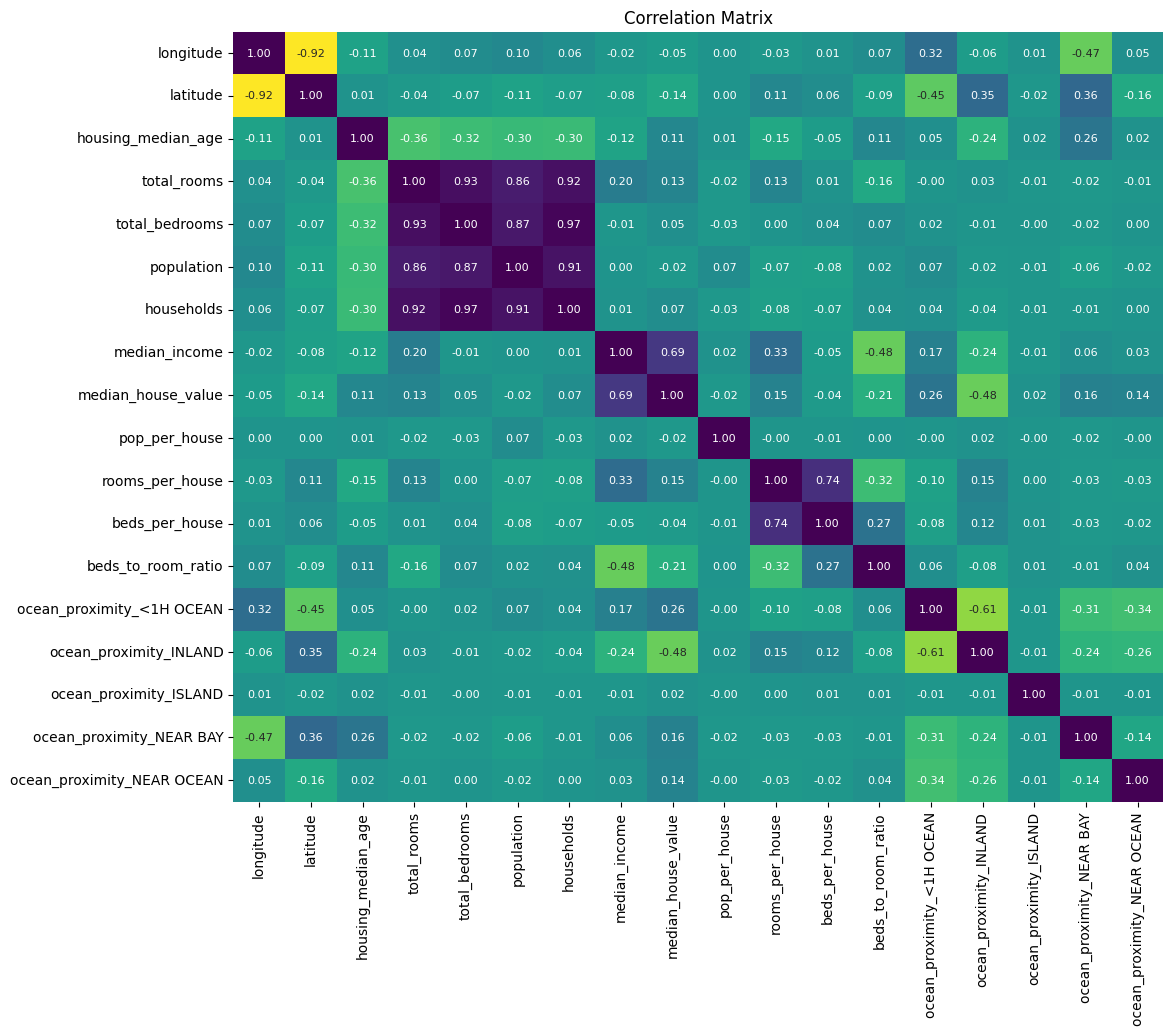

In [10]:
# Correlaiton matrix for numerical columns
corr = df_eda.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis_r', cbar=False, annot_kws={'size':8})
plt.title("Correlation Matrix")
plt.show()

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>],
       [<Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'pop_per_house'}>,
        <Axes: title={'center': 'rooms_per_house'}>,
        <Axes: title={'center': 'beds_per_house'}>],
       [<Axes: title={'center': 'beds_to_room_ratio'}>,
        <Axes: title={'center': 'ocean_proximity_<1H OCEAN'}>,
        <Axes: title={'center': 'ocean_proximity_INLAND'}>,
        <Axes: title={'center': 'ocean_proximity_ISLAND'}>],
       [<Axes: title={'center': 'ocean_proximity_NEAR BAY'}>,
        <Axes: title={'center': 'ocean_proximity_NEAR OCEAN'}>, <Axes: >,
        <Axe

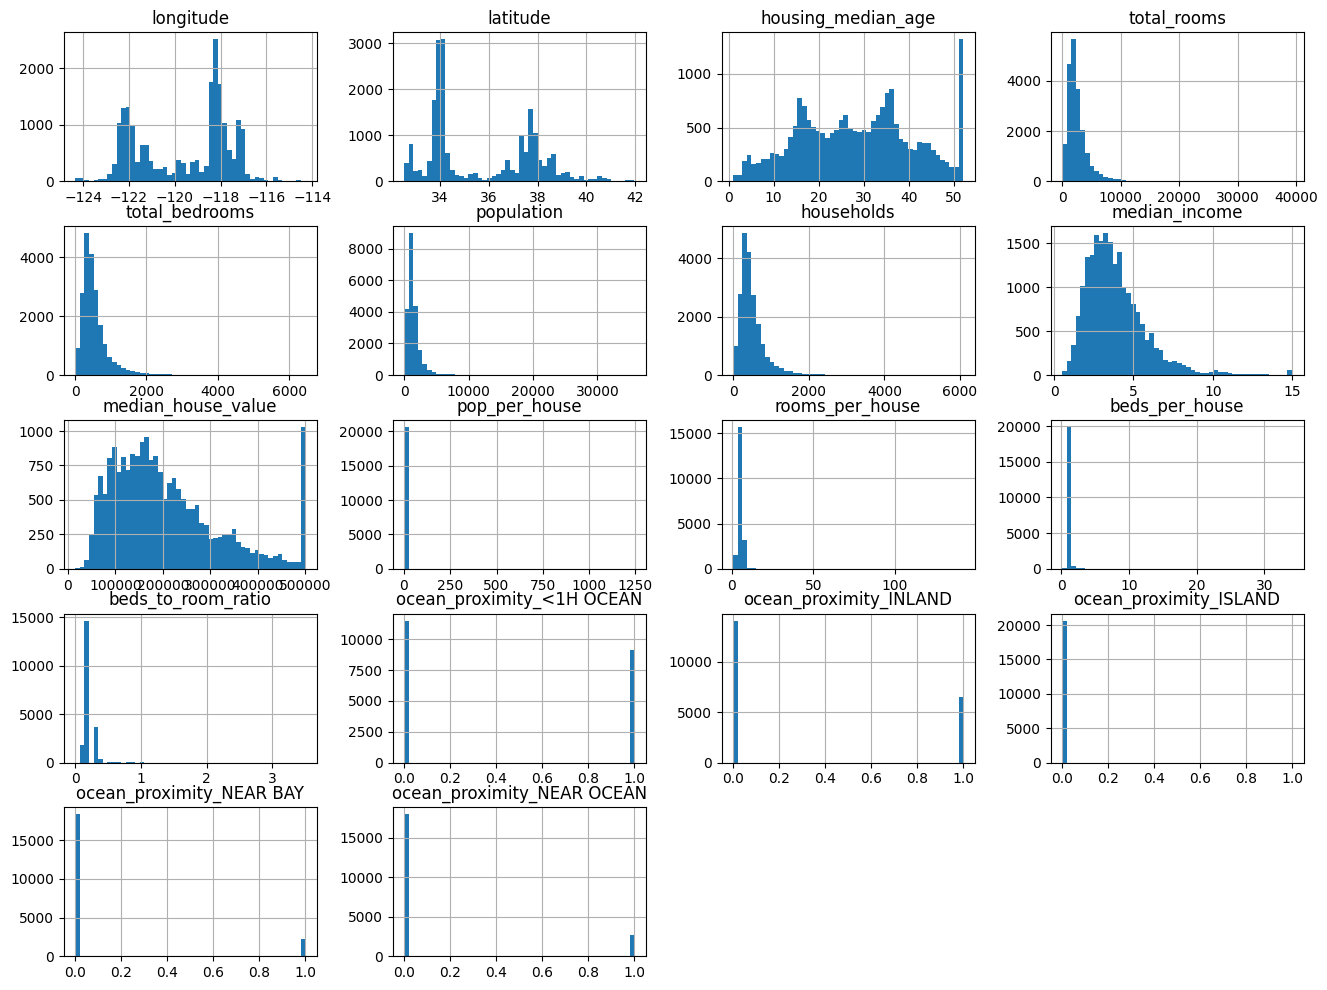

In [11]:
df_eda.hist(figsize=(16, 12), bins=50)

#df_eda.query('median_house_value == 500000').hist(figsize=(16, 12), bins=50)
#display(df_eda.median_house_value.max())

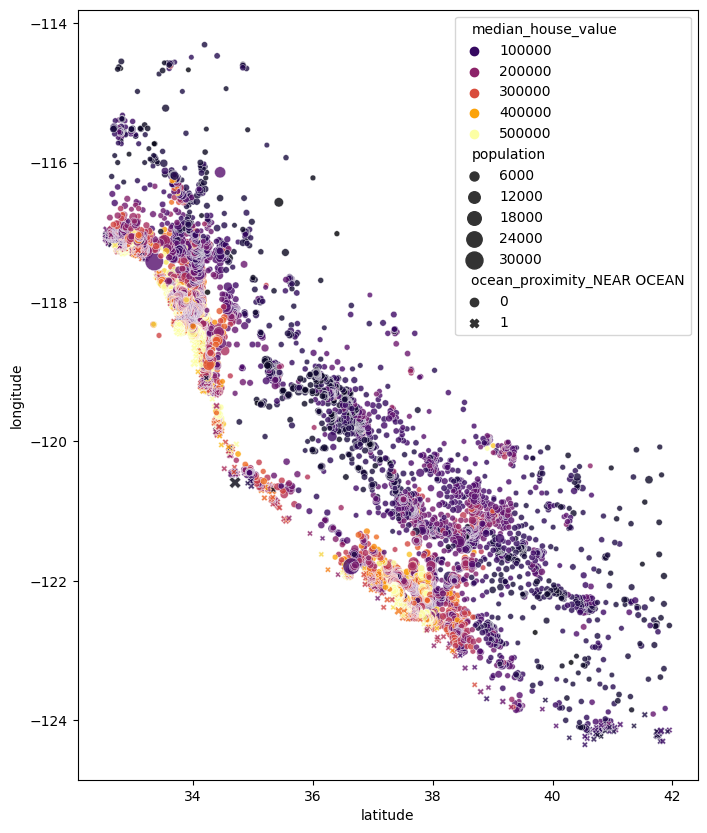

In [12]:
plt.figure(figsize=(8, 10))

# Create custom palette
cubehelix = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

# Create the scatter plot
sns.scatterplot(
    data=df_eda, 
    x='latitude', 
    y='longitude', 
    hue='median_house_value', 
    size='population', 
    sizes=(15, 175),
    style='ocean_proximity_NEAR OCEAN',
    #palette=cubehelix,
    palette='inferno',
    alpha=0.8
)

plt.show()

# Create Custom Functions, Transformers, and Estimators

# Test (Hold-Out) / Train Split

In [13]:
feature_col_names = df_raw.columns.drop('median_house_value')
target = df_raw.loc[:, 'median_house_value']
features_all = df_raw.loc[:, feature_col_names]

X_train, X_hold, y_train, y_hold = train_test_split(
    features_all,
    target,
    random_state=1,
    shuffle=True,
    stratify=None,
    test_size=0.20,
)

display(f'X_train Shape: {X_train.shape}   y_train Shape: {y_train.shape}')
display(f'X_hold Shape: {X_hold.shape}   y_hold Shape: {y_hold.shape}')

'X_train Shape: (16512, 9)   y_train Shape: (16512,)'

'X_hold Shape: (4128, 9)   y_hold Shape: (4128,)'

# Create Custom Functions, Transformers, and Estimators

In [14]:
# Define a noop_func which will be used as toggle on/off for the per_house_hold_features FunctionTransformer during grid search
def noop_func(df):
    return df


# Create passthrough transformer which will be used as "off" toggle during gridsearchCV for the full pipeline
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing happens in fit
    
    def transform(self, X, y=None):
        return X  # The data is unchanged


# Define custom function for per household column creation
def per_house_hold_features(df):
    df = (df
          .assign(
              num__pop_per_house=lambda df_: df_.num__population.div(df_.num__households).round(1),
              num__rooms_per_house=lambda df_: df_.num__total_rooms.div(df_.num__households).round(1),
              num__beds_per_house=lambda df_: df_.num__total_bedrooms.div(df_.num__households).round(1),
              num__beds_to_room_ratio=lambda df_: df_.num__total_bedrooms.div(df_.num__total_rooms).fillna(0).round(1),
          )
         )
    return df

# Create Pre-Processing Pipeline

In [15]:
# Define the preprocessing for numerical columns
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
])

# Define the preprocessing for categorical columns 
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))  # handle_unknown='ignore' to handle any unseen category in future data
])

# Create the ColumnTransformer to apply different transformation to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat', cat_pipeline, make_column_selector(dtype_exclude=np.number))
    ],
    #n_jobs=-1,
    sparse_threshold=0,
)

# Fit and transform the training data
#X_train_preprocessed = preprocessor.fit_transform(X_train)

#display(X_train_preprocessed.isna().any())
#display(X_train_preprocessed.info())

# Create Processing Pipeline (includes Feature Creation & Engineering)

In [16]:
# Construct the per-household feature creation transformer
per_household_transformer = FunctionTransformer(func=per_house_hold_features, validate=False, accept_sparse=False, feature_names_out=None)

# Construct normalization process for certain columns
normalizer = ColumnTransformer(
    transformers=[
        ('norm', PowerTransformer(method='yeo-johnson', standardize=False), [
            'num__total_rooms', 
            'num__total_bedrooms', 
            'num__population', 
            'num__households',
            'num__rooms_per_house',
            'num__beds_per_house',
            'num__housing_median_age',
            'num__median_income',
            'num__pop_per_house',
            #'nun__beds_to_room_ratio'
        ]),
    ],
    remainder='passthrough',
    sparse_threshold=0,
    #n_jobs=-1
)

# Construct scaling process for certain columns
scaler = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(),  make_column_selector(pattern='^(?!remainder__cat).*$')),
    ],
    remainder='passthrough',
    sparse_threshold=0,
    #n_jobs=-1
)


# Setup Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Define the processing and feature-creation pipeline
processor = Pipeline([
    ('new', per_household_transformer),
    ('poly', poly),
    ('norm', normalizer),
    ('scale', scaler),
])

# Create Feature Selection, and Dimensionality Reduction Steps

In [17]:
kbest = SelectKBest(score_func=f_regression, k='all')       
pca = PCA(n_components=10, whiten=False)

# Create ML Models & Custom Regressors

In [18]:
# LR Model
lr_model = LinearRegression(
    fit_intercept=True,
    positive=False,
    #n_jobs=-1,
)

# Lasso Model
lasso_model = Lasso(
    alpha=1,
    max_iter=1000,
)

# Ridge Model
ridge_model = Ridge(
    alpha=1,
    solver='auto',
    max_iter=1000,
    
)

# ElastiNet Model
enet_model = ElasticNet(
    alpha=1,
    l1_ratio=0.5,
    max_iter=1000,
)


# Ensemble Model
ensemble_model = VotingRegressor(
    estimators=[
        ('lr', lr_model),
        #('lasso', lasso_model),
        #('ridge', ridge_model),
        #('enet', enet_model),
    ],
    weights=[
        1.00, 
        #0.25, 
        #0.25,
        #0.25,
    ] 
)


# Define custom regressor to incorporate business domain parameters and guardrails in a pipeline-accessible approach that can be optimized during grid search
class CustomMetaRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_models, cap=500001, floor=10000):
        """
        Initialize the Meta Regressor with base models, a cap, and a floor for predictions.
        :param base_models: A list or ensemble of base models.
        :param cap: The maximum allowed predicted value.
        :param floor: The minimum allowed predicted value.
        """
        self.base_models = base_models
        self.cap = cap
        self.floor = floor

    def fit(self, X, y):
        """
        Fit the base models on the given training data.
        :param X: Features from the training data.
        :param y: Labels from the training data.
        """
        # Fit the ensemble model
        self.base_models.fit(X, y)
        return self

    def predict(self, X):
        """
        Predict using the base models and apply capping and flooring to the predictions in line with data set and business logic
        :param X: Features from the data to predict on.
        :return: The capped and floored predictions.
        """
        # Predict using the ensemble model
        predictions = self.base_models.predict(X)
        # Apply custom logic: Cap predictions at self.cap and floor at self.floor
        return np.clip(predictions, self.floor, self.cap)

    
# Wrap your model with the custom meta regressor that clips the predictions in line with dataset business domain logic
meta_model = CustomMetaRegressor(base_models=ensemble_model, cap=500001, floor=5000)

# Wrap the custom meta model with TransformedTargetRegressor to create placeholder for target transformation as needed
#target_transformer = QuantileTransformer()

meta_model_tt = TransformedTargetRegressor(
    regressor=meta_model, 
    #transformer=target_transformer,
    func=lambda x: x, 
    inverse_func=lambda x: x,
)  

# Define a Conditional Parameter Grid

In [19]:
# Define ensemble model weight scenarios for gridsearch. values are in this order: LR, Lasso, Ridge, ElasticNet
weight_options = [
    [1.00],
    #[0.25, 0.25, 0.25, 0.25], 
    #[0.7, 0.1, 0.1, 0.1],
]

# Setup conditional param grid for gridsearchCV
def get_base_params():
    return {
        'preprocess__num__imputer__strategy': ['median'],
        'preprocess__cat__imputer__strategy': ['most_frequent'],
        'process__new__func': [per_house_hold_features],
        'process__norm__norm': [
            PowerTransformer(method='yeo-johnson', standardize=False), 
            PassthroughTransformer()
        ],
        'process__scale__scale': [
            StandardScaler(), 
            QuantileTransformer(output_distribution='normal'),
            #QuantileTransformer(output_distribution='uniform'),
        ],
        'meta_model_tt__regressor__cap': [500001],
        'meta_model_tt__regressor__floor': [10000],
        'meta_model_tt__regressor__base_models__weights': weight_options,
        #'meta_model_tt__regressor__base_models__lasso__alpha': [1],
        #'meta_model_tt__regressor__base_models__enet__alpha': [1],
        #'meta_model_tt__regressor__base_models__enet__l1_ratio': [0.5],
    }

# Definte conditional parameters given PolynomialFeatures will be ON or will be left to optimization to toggle ON/OFF
def get_poly_params(poly_on=True):
    if poly_on:
        return {
            'process__poly': [PolynomialFeatures(degree=2, include_bias=False)],
            'feat_select__k': [40], 
            'pca': [
                PCA(n_components=30, whiten=True), 
                PassthroughTransformer()
            ]
        }
    else:
        return {
            'process__poly': [
                PolynomialFeatures(degree=2, include_bias=False), 
                PassthroughTransformer()
            ],
            'feat_select__k': ['all'],
            'pca': [
                PCA(n_components=None, whiten=True), 
                PassthroughTransformer()
                   ]
        }

    
# Grid when Polynomial Features are on
param_grid_1 = {**get_base_params(), **get_poly_params(poly_on=True)}

# Grid when Polynomial Features are either on or off
param_grid_2 = {**get_base_params(), **get_poly_params(poly_on=False)}

param_grid = [param_grid_1, param_grid_2]

# Create Main Pipeline & Perform Grid Search Cross Validation 

In [20]:
# Setup main pipeline
main_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('process', processor),
    ('feat_select', kbest),
    ('pca', pca),
    ('meta_model_tt', meta_model_tt)
])

# Assign param grid
param_grid_combo = [param_grid_1, param_grid_2]

# Modify here for multi-scoring: RMSE (negated for minimization) and R2
scoring = {'RMSE': 'neg_root_mean_squared_error', 'R2': 'r2'}

grid_search = GridSearchCV(
    estimator=main_pipeline, 
    param_grid=param_grid,
    scoring=scoring,
    refit='RMSE',       
    cv=10,
    n_jobs=-1
)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Create final fully transformed X_train using the best found parameters
X_train_final = Pipeline(grid_search.best_estimator_.steps[:-1]).fit_transform(X_train, y_train)

# Get the best score and parameters
mean_cv_rmse = -grid_search.cv_results_['mean_test_RMSE']  
mean_cv_r2 = grid_search.cv_results_['mean_test_R2']
best_rmse_score = -grid_search.best_score_  
best_params = grid_search.best_params_

# Calculate RMSE and R2 on holdout data using best estimator
y_pred_hold = grid_search.predict(X_hold)
holdout_rmse = np.sqrt(mean_squared_error(y_hold, y_pred_hold))
holdout_r2 = r2_score(y_hold, y_pred_hold)  

# Display results: parameters, hyper-parameters, and metrics
def display_results(value, desc, color='black', font_weight='normal', font_size='14px'):
    display(HTML(f"<span style='color: {color}; font-weight:{font_weight}; font-size:{font_size};'>{desc}: {value}</span>"))

# Displaying the results with increased font size and bold text for emphasis
display_results(f"{best_rmse_score:.1f}", "Best CV RMSE", color='turquoise', font_weight='bold', font_size='20px')
display_results(f"{mean_cv_rmse[grid_search.best_index_]:.1f}", "Mean CV RMSE", color='turquoise', font_weight='bold', font_size='20px')
display_results(f"{mean_cv_r2[grid_search.best_index_]:.2f}", "Mean CV R2 Score", color='orange', font_weight='bold', font_size='20px')
display_results(f"{holdout_rmse:.1f}", "Holdout RMSE", color='turquoise', font_weight='bold', font_size='20px')
display_results(f"{holdout_r2:.2f}", "Holdout R^2 Score", color='orange', font_weight='bold', font_size='20px')
display_results(best_params, "Best parameters", color='white', font_weight='bold', font_size='16px')

In [21]:
# Display pipeline structure and grid search results
display(main_pipeline.named_steps)
cv_results = pd.DataFrame(grid_search.cv_results_)
#display(cv_results.columns)
#display(cv_results) 

{'preprocess': ColumnTransformer(sparse_threshold=0,
                   transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median'))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78331441ff40>),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78331447b010>)])

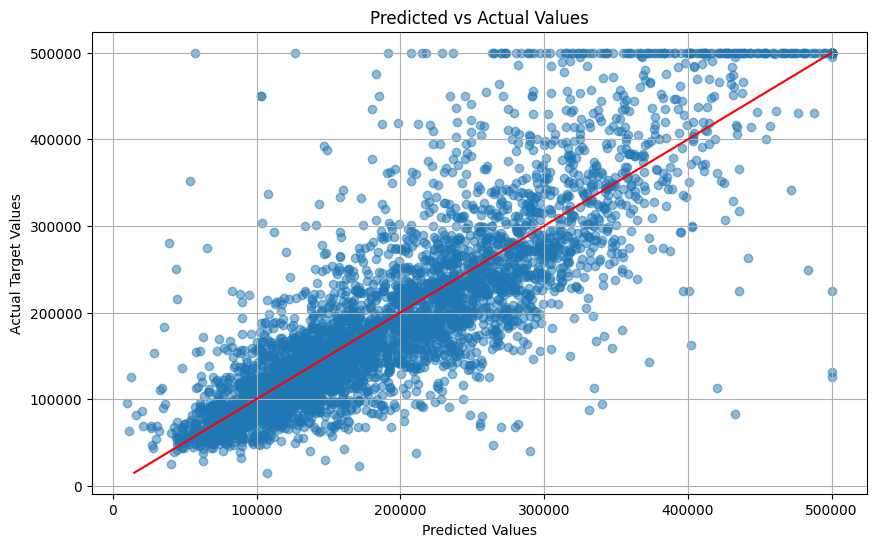

In [22]:
# Create a scatter plot comparing predictions and actuals on hold-out dataset
plt.figure(figsize=(10,6)) 
plt.scatter(y_pred_hold, y_hold, alpha=0.5) 
plt.title('Predicted vs Actual Values') 
plt.xlabel('Predicted Values') 
plt.ylabel('Actual Target Values') 
plt.grid(True) 
plt.plot([min(y_hold), max(y_hold)], [min(y_hold), max(y_hold)], color='red') 
plt.show()

# Create PCA cumulative variance plot

'Total number of components: 152'

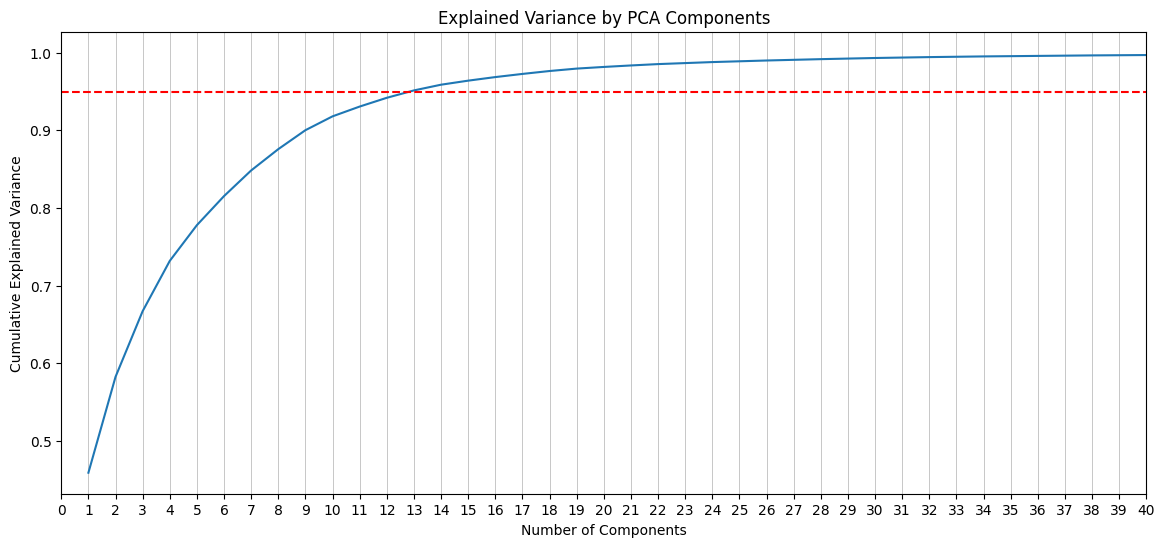

In [23]:
# Extract preprocessing and feature processing steps (up to but not including PCA)
pre_pca_pipeline = Pipeline(main_pipeline.steps[:-2]) 
X_transformed = pre_pca_pipeline.fit_transform(X_train, y_train)

# Fit PCA to the transformed data using n_components=None which is the default and maintains all components
pca = PCA(n_components=None).fit(X_transformed) 

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

display(f"Total number of components: {pca.n_components_}")

# Create the elbow plot
plt.figure(figsize=(14, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)

plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  
plt.xlim(0, 40)  
plt.xticks(np.arange(0, 41, 1))  
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5') 

plt.show()